# Globant Data Science Technical Assessment

#### Project: Diabetes 130-US hospitals for years 1999-2008
##### Data available on: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In this dataset you have 3 different outputs:
1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe
your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last
one, however, the reason could be the state of the patient.

Your task is either to classify a patient-hospital outcome or to cluster them aiming at
finding patterns that give a distinct insight.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a
Rmarkdown report (in case you use R) and make it available for us, i.e. github.

Hint to success in your quest: Develop and stay clear of the data science process you'll
perform over the dataset and highlight important aspects you might consider affordable
to discuss over.

In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow import keras

# Display all columns for better visualization
pd.set_option('display.max_columns', None) 

# Initial data reading
df = pd.read_csv("C:/Users/CArrieta/Downloads/diabetic_data.csv")
print("The original data has {} features and {} observations".format(df.shape[1], df.shape[0]))
display(df.head(3))
display(df.info())

The original data has 50 features and 101766 observations


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

According to the documentation, the features 'admission_type_id', 'discharge_disposition_id' and 'admission_source_id' should be categorical instead of numerical, and for each one we can see different categories for 'NULL', 'Not Mapped' and 'Unknown/Invalid'. We will merge those categories into a single one per feature.

In [2]:
df['admission_type_id'] = df['admission_type_id'].replace({6:5, 8:5}).astype('str')
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({25:18, 26:18}).astype('str')
df['admission_source_id'] = df['admission_source_id'].replace({15:17, 20:17}).astype('str')

## 1. Exploratory Data Analysis (EDA) & Data Preprocessing

### 1.1 Looking for null values and uninformative data

In [3]:
na = pd.DataFrame(df.isna().sum()).rename(columns={0:'# Null Values'})
display(na[na['# Null Values']>0])

,# Null Values


Here we see that that pandas didnt managed to identify the missing values. However, from the documentation we know that some columns have null values. Also, checking the first few rows we see that some columns take the value of '?'.

In [4]:
na = {}
for e in df.columns:
    if df[e].dtype == object:
         if df[e][df[e] == '?'].count() > 0:
            na[e] = [df[e][df[e] == '?'].count(), df[e][df[e] == '?'].count()/df.shape[0]]
pd.DataFrame.from_dict(na).T.rename(columns={0:'# of nulls', 1:'As percentage'})

,# of nulls,As percentage
race,2273.0,0.022336
weight,98569.0,0.968585
payer_code,40256.0,0.395574
medical_specialty,49949.0,0.490822
diag_1,21.0,0.000206
diag_2,358.0,0.003518
diag_3,1423.0,0.013983


Now we see that at least 6 columns have null values. We see that payer_code, medical_specialty and weight have a very high amount of null values, so we will not use them as part of our models, since any attempt of imputation could seriously affect the variance without contributing to the models performance.

Regarding the other features, we see that they are difficult to impute since the 3 diag_x features contain hundreds of categories. This means that imputing with the mode could result in high innacuracies. Because of this I believe that imputation through kNN is the most appropiate for the case, since using the info from other columns to find similar observations is likely to result in a more precise imputation. 

Since the diagnosis are probably very informative features, it would be ideal to preserve them with kNN imputation. However, given the number of categories that would later arise from OneHotEncoding these features, I have decided to drop them for now. If the model performs poorly, we can later consider processing these features.

In [5]:
df.drop(['weight','payer_code','medical_specialty','diag_1','diag_2','diag_3'], axis = 1, inplace=True)
df.replace({'?':np.nan}, inplace=True)

Now we will explore other undesirable patterns in the data by checking the possible categories on each categorical feature.

In [6]:
for e in df.columns:
    if df[e].dtype == object:
        print(e, df[e].unique())

race ['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male' 'Unknown/Invalid']
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
admission_type_id ['5' '1' '2' '3' '4' '7']
discharge_disposition_id ['18' '1' '3' '6' '2' '5' '11' '7' '10' '4' '14' '8' '13' '12' '16' '17'
 '22' '23' '9' '20' '15' '24' '28' '19' '27']
admission_source_id ['1' '7' '2' '4' '5' '6' '17' '3' '8' '9' '14' '10' '22' '11' '25' '13']
max_glu_serum ['None' '>300' 'Norm' '>200']
A1Cresult ['None' '>7' '>8' 'Norm']
metformin ['No' 'Steady' 'Up' 'Down']
repaglinide ['No' 'Up' 'Steady' 'Down']
nateglinide ['No' 'Steady' 'Down' 'Up']
chlorpropamide ['No' 'Steady' 'Down' 'Up']
glimepiride ['No' 'Steady' 'Down' 'Up']
acetohexamide ['No' 'Steady']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
tolbutamide ['No' 'Steady']
pioglitazone ['No' 'Steady' 'Up' 'Down']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
aca

We can see that the features 'citoglipton' and 'examide' takethe same value for all observations so they bring no useful information on predicting 'readmitted' and therefore we will delete them.
Also, according to the documentation, 'encounter_id' and 'patient_nbr' are ID's so we can safely delete them.

In [7]:
df.drop(['citoglipton', 'examide', 'encounter_id', 'patient_nbr'], axis = 1, inplace=True)

With this we are confident enough that there is no more missing data.

### 1.2 Distribution of classes
Since our target feature is 'readmitted' in this case, we will explore the values it takes to make sure it is consistent and we will also check the frequency of each category to explore the presence of class imbalance.

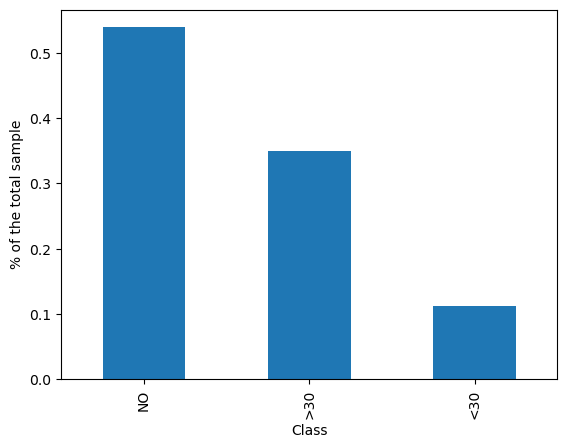

In [8]:
df['readmitted'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('% of the total sample')
plt.show()

From the graph above we can say that both the '>30' and '<30' classes are moderately imbalanced. To deal with this we could experiment trying undersampling or oversampling (SMOTE) to get more balanced classes, but since the imbalance is not a heavy one, we will continue with the data as it is, using StratifiedKFold to deal with this as we will see later.

### 1.3 Descriptive Analysis

We start by plotting histograms and scatterplots with linear regressions across all numerical features. This will help us understand each feature's distribution algong with the nature of the realtionships between variables. All this information guides us on taking decisions such as the need of standardizing/scaling our data and the kinds of models we should try.

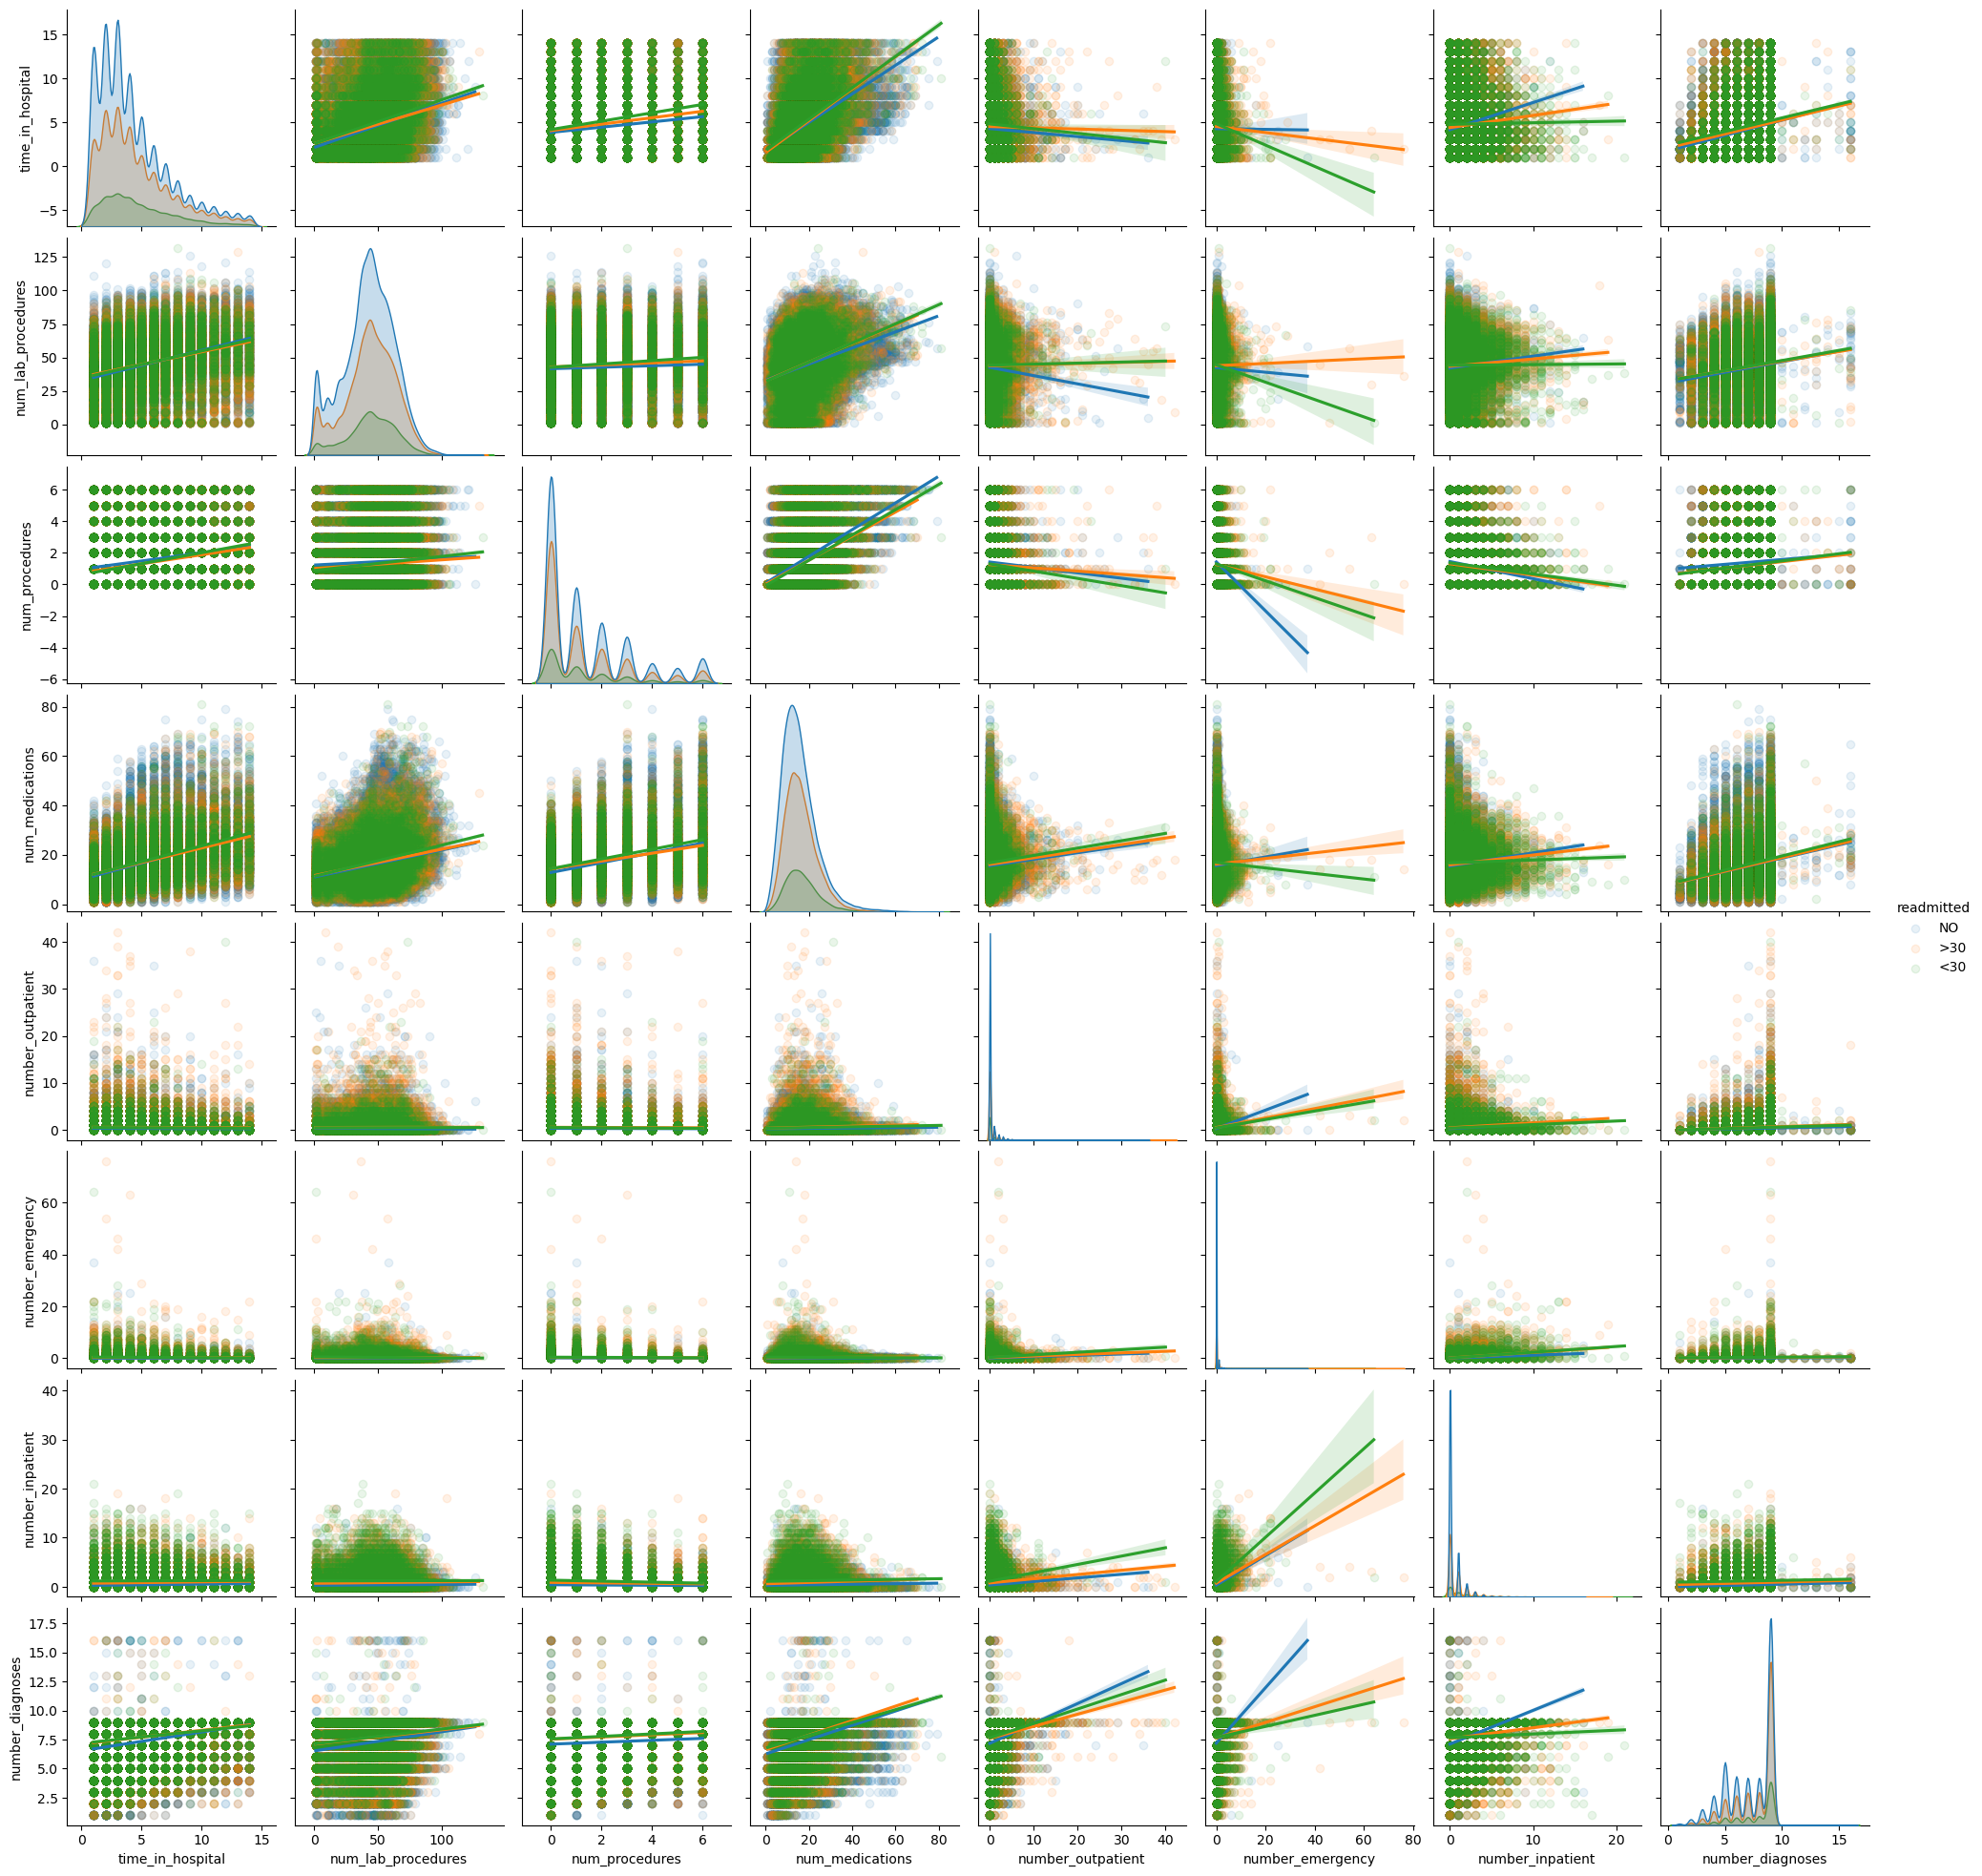

In [9]:
sns.pairplot(df, kind='reg', hue='readmitted', plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.show()

This pairplot is very informative before starting any kind of modeling. First, on the density plots on the diagonal we can see that there are multiple distributions, some highly skewed. And checking the scatterplots we see many relationships that are clearly not linear.

What this is telling us is that some scaling and standardizations is probably needed, and that linear models might not be able to correctly represent patterns in the data. In this cases, non-linear models like Random Forest, Gradient Boosting and Neural Networks are usually more effective.

Next, we build a correlation matrix to explore collinearity within our dataset.

In [10]:
df.corr().style.background_gradient(cmap='coolwarm')

C:\Users\CArrieta\AppData\Local\Temp\ipykernel_15576\543879950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm')


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


As we can see, there is no strong correlations among the numerical variables, the strongest being 0.46 between the number of medications and time in the hospital. With this, we can say that feature reduction with PCA or t-SNE might not be appropriate for this case. However, given the great amount of variables that will arise from Dummy codifying all categorical variables, we will perform feature selection with SelectKBest.

In [11]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


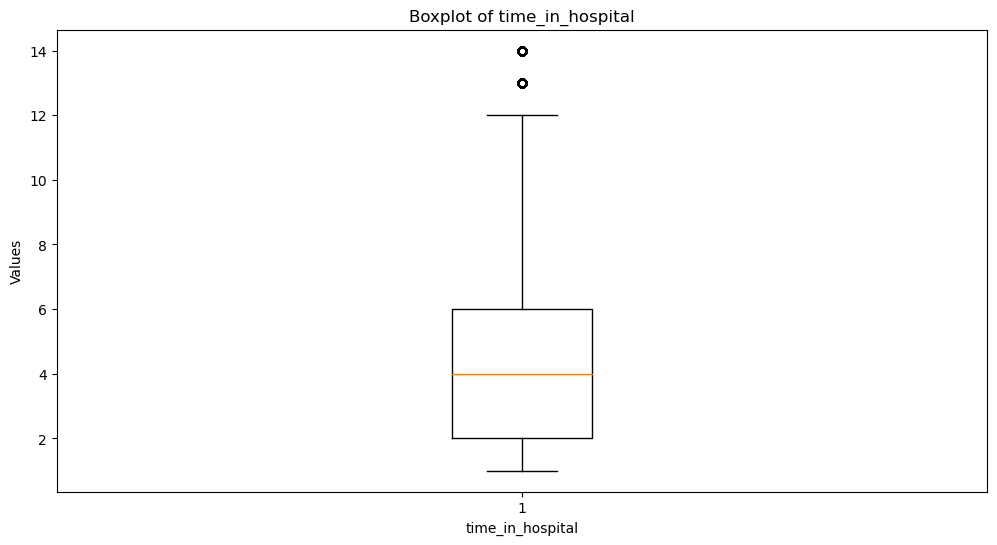

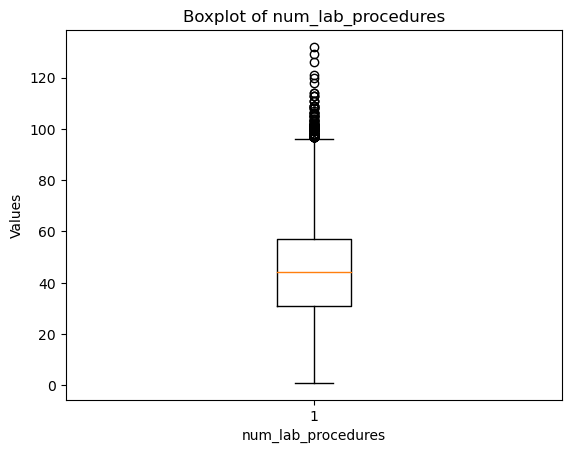

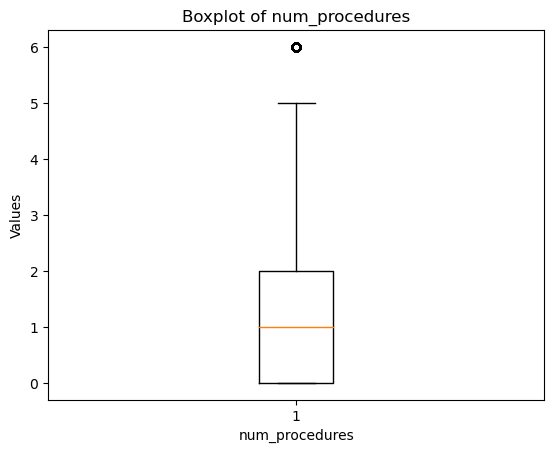

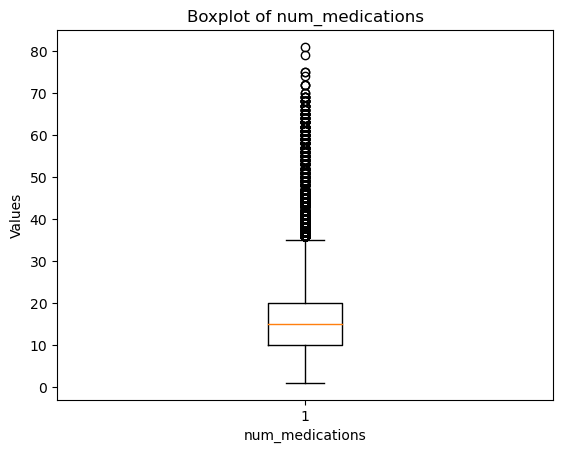

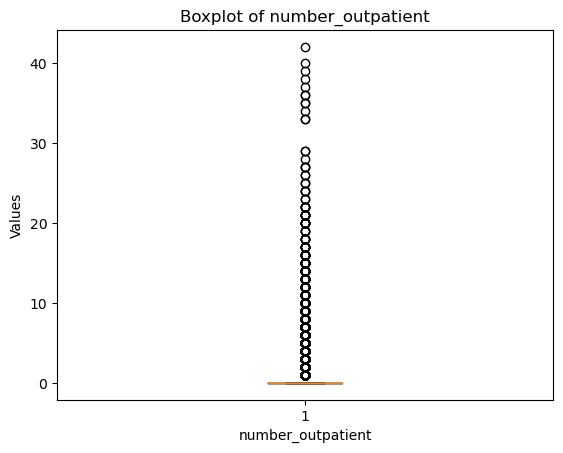

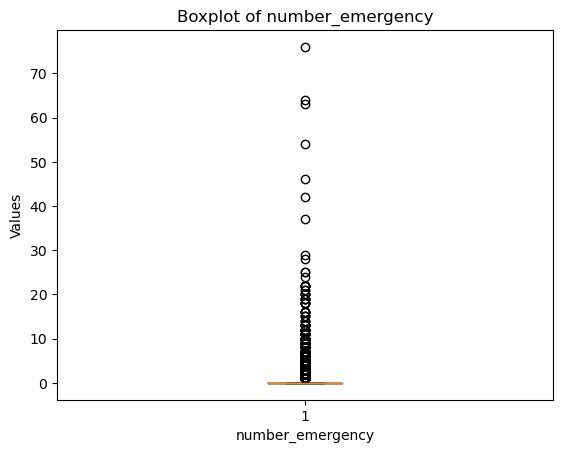

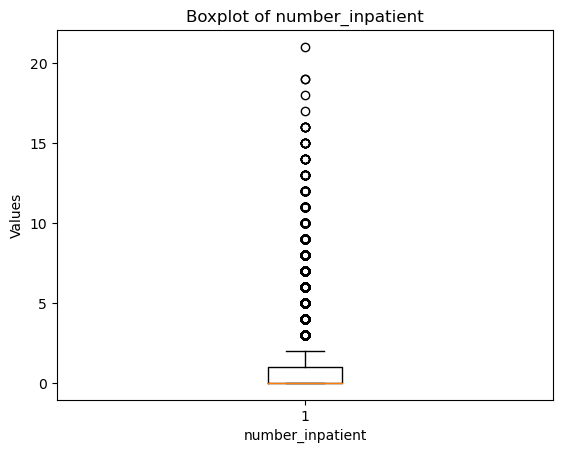

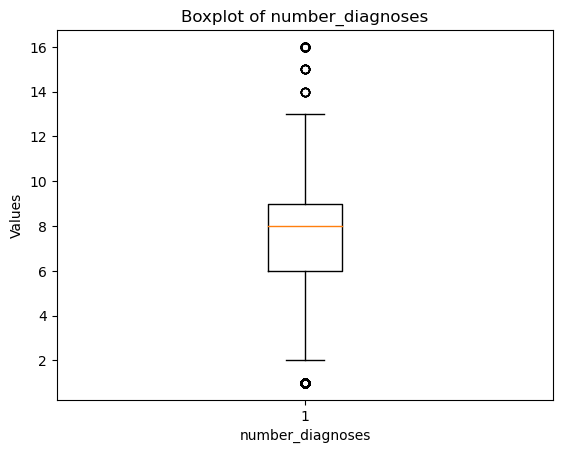

In [12]:
plt.figure(figsize=(12, 6))
for col in df.select_dtypes(include='number').columns:
    plt.boxplot(df[col])
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.title(f'Boxplot of {col}')
    plt.show()

From the boxplots we can conclude that there is a high presence of outliers in the dataset numerical features.

In [13]:
for i in [e for e in df.columns if df[e].dtype == object]:
    print("\n" + i + " frequency %:")
    print(df[i].value_counts(normalize=True))
    print(i + " cross-frequency % with readmitted:")
    print(pd.crosstab(df[i], df['readmitted'], rownames=[i], colnames=['readmitted'], normalize=True))


race frequency %:
Caucasian          0.764868
AfricanAmerican    0.193079
Hispanic           0.020474
Other              0.015137
Asian              0.006443
Name: race, dtype: float64
race cross-frequency % with readmitted:
readmitted            <30       >30        NO
race                                         
AfricanAmerican  0.021660  0.066678  0.104741
Asian            0.000653  0.001618  0.004171
Caucasian        0.086358  0.272622  0.405888
Hispanic         0.002131  0.006453  0.011890
Other            0.001457  0.004483  0.009197

gender frequency %:
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64
gender cross-frequency % with readmitted:
readmitted            <30       >30        NO
gender                                       
Female           0.060452  0.191793  0.285341
Male             0.051147  0.157489  0.253749
Unknown/Invalid  0.000000  0.000000  0.000029

age frequency %:
[70-80)     0.256156
[60-70)

### 1.4 Scaling and Standarization

From the descriptive analysis we can say that the features show different scales and different distributions. Also, from the boxplots we can tell that there are some outliers that could be affecting our model's performance, and that is why we choose RobustScaler for the purpose.

Next, we first isolate the target feature before applying RobustScaler.

In [14]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

In [15]:
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = RobustScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

### 1.5 Feature Selection

We get the dummy variables from all categorical features and now we have prepared all features to perform feature selection.

In [16]:
X = pd.get_dummies(X, columns=[e for e in X.columns if X[e].dtype == object], drop_first=True)

In [17]:
fs = SelectKBest(score_func=f_classif, k=len(X.columns))
X_selected = fs.fit_transform(X, y)

print('Size Before SelectKBest = {}'.format(X.shape))

new_features = [] # The list of features less than the p-values
drop_features = [] # The list of features higher than the p-values

for i in range(len(X.columns)):
    if fs.pvalues_[i] <= 0.01 and fs.scores_[i] >= 5: # Here we use a threshold of 0.01 and a t_score of 5
        new_features.append(X.columns[i])
    else:
        drop_features.append(X.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = X.columns
X_selected_final = X_selected_final[new_features]

print('Size After SelectKBest = {}'.format(X_selected_final.shape))

Size Before SelectKBest = (101766, 123)
Size After SelectKBest = (101766, 68)


### 2. Modeling

Since we are dealing with a moderately unbalanced target feature, we're going to use StratifiedKFold crossvalidation since it preserves the target class distribution on each fold.

Regarding the Hiperparameter tuning for each model, it would be desirable to try approximations such as Bayesian Optimization with optuna, but in the spirit of keeping the computation time short we will use RandomizedSeachCV with 80% of the data, and we will leave a 20% test sample to calculate final classification metrics.

Its worth mentioning that more models and different approaches could be tried with access to other computational resources sucha as GPU, TPU, paralell computing with Spark or optimized computation with cloud services such as AWS compute-optimized EC2 instances with SageMaker. I tried some theoretical approaches but it never hurts to try more and different options with more powerful computational resources.

In [18]:
# LightGBM has some troubles with special characters in feature ames, so we use regex to clean the names
X_selected_final = X_selected_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

XTrain, XTest, yTrain, yTest = train_test_split(X_selected_final, y, test_size=0.2, random_state=0)

In [19]:
params = {
        'max_depth': [None, 10, 15, 20],
        'n_estimators': [100, 200, 300, 400],
        'max_features': ['log2', 'sqrt', None],
        'max_samples': [None, 0.6, 0.8]
        }
rf = RandomForestClassifier(random_state=0)
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 1001)
rf_model = RandomizedSearchCV(estimator=rf,
                  param_distributions=params,
                  scoring='f1_weighted',
                  cv=skf.split(XTrain,yTrain),
                  n_jobs=-1,
                  verbose=2,
                  n_iter=15)
rf_model.fit(XTrain, yTrain)
print("Best Params:", rf_model.best_params_)
print(classification_report(yTest,rf_model.best_estimator_.predict(XTest)))

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Params: {'n_estimators': 200, 'max_samples': 0.8, 'max_features': None, 'max_depth': 20}
              precision    recall  f1-score   support

         <30       0.42      0.04      0.07      2241
         >30       0.49      0.37      0.42      7116
          NO       0.62      0.83      0.71     10997

    accuracy                           0.58     20354
   macro avg       0.51      0.41      0.40     20354
weighted avg       0.55      0.58      0.54     20354



In [20]:
params = {
        'max_depth': [None, 10, 15, 20],
        'lambda': [0, 0.4, 0.8, 1],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'n_estimators': [100, 200, 300, 400]
        }
lg = lgb.LGBMClassifier()
lg_model = RandomizedSearchCV(estimator=lg,
                  param_distributions=params,
                  scoring='f1_weighted',
                  cv=skf.split(XTrain,yTrain),
                  n_jobs=-1,
                  verbose=2,
                  n_iter=15)
lg_model.fit(XTrain, yTrain)
print("Best Params:", lg_model.best_params_)
print(classification_report(yTest,lg_model.best_estimator_.predict(XTest)))

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
Best Params: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'lambda': 0, 'colsample_bytree': 1.0}
              precision    recall  f1-score   support

         <30       0.42      0.04      0.07      2241
         >30       0.50      0.39      0.44      7116
          NO       0.62      0.83      0.71     10997

    accuracy                           0.59     20354
   macro avg       0.52      0.42      0.41     20354
weighted avg       0.56      0.59      0.55     20354



Epoch 1/20
2036/2036 [==============================] - 4s 2ms/step - loss: 0.8924 - categorical_accuracy: 0.5760 - val_loss: 0.8828 - val_categorical_accuracy: 0.5839
Epoch 2/20
2036/2036 [==============================] - 3s 1ms/step - loss: 0.8765 - categorical_accuracy: 0.5835 - val_loss: 0.8800 - val_categorical_accuracy: 0.5872
Epoch 3/20
2036/2036 [==============================] - 3s 1ms/step - loss: 0.8717 - categorical_accuracy: 0.5869 - val_loss: 0.8787 - val_categorical_accuracy: 0.5807
Epoch 4/20
2036/2036 [==============================] - 3s 2ms/step - loss: 0.8689 - categorical_accuracy: 0.5879 - val_loss: 0.8767 - val_categorical_accuracy: 0.5875
Epoch 5/20
2036/2036 [==============================] - 3s 2ms/step - loss: 0.8658 - categorical_accuracy: 0.5892 - val_loss: 0.8762 - val_categorical_accuracy: 0.5874
Epoch 6/20
2036/2036 [==============================] - 3s 2ms/step - loss: 0.8636 - categorical_accuracy: 0.5900 - val_loss: 0.8777 - val_categorical_accuracy:

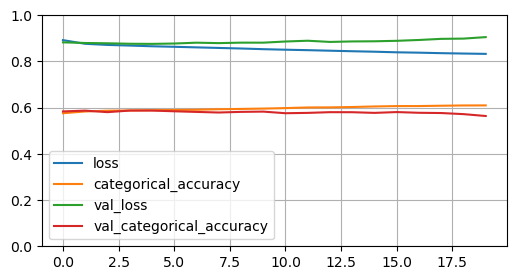

637/637 [==============================] - 1s 1ms/step - loss: 0.8935 - categorical_accuracy: 0.5735
The model has a 0.5735481977462769 score on weighted accuracy.


In [25]:
yTrain = pd.get_dummies(yTrain)
yTest = pd.get_dummies(yTest)

model = keras.models.Sequential()
model.add(keras.layers.Dense(XTrain.shape[1], activation='relu', input_shape=(XTrain.shape[1],)))
model.add(keras.layers.Dense(34, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) #, keras.metrics.F1Score(average='weighted')])

history = model.fit(XTrain, yTrain, epochs=20, validation_split=0.2)

pd.DataFrame(history.history).plot(figsize=(6, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

print(f"The model has a {model.evaluate(XTest, yTest)[1]} score on weighted accuracy.")

After carrying an initial Data Science process we see that this dataset presents two main challenges. The first one is the presence of multiple categorical variables with hundreds of categories. Due to the need of encoding categorical variables into dummy variables, we face the so called 'Curse of Dimensionality'. The second one is a moderate class imbalance. Both this problems mean that getting models with an acceptable performance can mean a lot of time experimenting with different techniques to deal with them. On this script we tried some intuitive approaches to this kind of scenarios, but there's a lot of other options that could be tried.

Its key mentioning that the Data Science process is completly iterative and on each stage is likely that you find something that makes you review past stages. Here we tried 3 models all of the non-linear because of what was discussed on the EDA phase. The first 2 models are tree-based, widely recognized for their flexibility. Specifically I chose LightGBM because its specifically designed to handle categorical features. And the 3rd model is a neural network with one hidden layer. 

I tried to use F1 weighted as the scoring metric, since the weighting by each class proportion is probably the most appropriate for the case. However, it is currently not working appropriately in Keras, I used weighted accuracy for the last model.

We dont see big differences in performance metrics across the trained models, and none of them has a high accuracy. Since we excluded the current patient diagnosis, its possible that including those variables could improve the model's performance. Also, trying to balance the classes on 'readmitted' with undersampling or oversampling techniques could improve performance, but its possible that patient readmission doesnt entierly depends on the variables we're considering within this dataset. The class imbalance seems to be a key factor here since the minoritary class is the one with the worst metrics on the first two models, where we see these models consistently fail at predicting this class. This is probably the reason why LightGBM is slightly better, since Gradient Boosting techniques use the errors from previous models to try a better prediction for misclassified observations.

Having all this in mind, this script would enter in a cycle of reviewing to try and improve the models performance until we find a good enough model for the purpose. Then the model could be made available for user interaction through an API or loading the model in a cloud service.